In [ ]:
!pip install comet_ml

In [ ]:
import comet_ml
import getpass, os

os.environ["COMET_API_KEY"] = getpass.getpass("Paste your COMET API KEY: ")

Paste your COMET API KEY: ··········


In [ ]:
experiment = comet_ml.Experiment(project_name="cnn-visualizations")

COMET INFO: Experiment is live on comet.ml https://www.comet.com/team-comet-ml/cnn-visualizations/bd7ea9f29c144ed993b757a8c2a750d7



In [ ]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch, torchvision
import torchvision.models as models
from torch.autograd import Variable
from torchvision import utils

In [ ]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-11-29 18:59:45--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.249.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.249.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.7’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.003s  

2020-11-29 18:59:45 (12.9 MB/s) - ‘imagenet_class_index.json.7’ saved [35363/35363]



In [ ]:
with open("./imagenet_class_index.json", "r") as f:
    class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [ ]:
! curl 'https://images.unsplash.com/photo-1513245543132-31f507417b26?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxzZWFyY2h8MzN8fGNhdHxlbnwwfHwwfA%3D%3D&auto=format&fit=crop&w=500&q=60' -o cat.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0  2743k      0 --:--:-- --:--:-- --:--:-- 2794k


In [ ]:
from PIL import Image, ImageFilter
from torchvision import datasets, transforms

preprocess = transforms.Compose(
    [
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

invert_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.255],
)

In [ ]:
img_id = "cat.png"

input_image = Image.open(f"./{img_id}")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

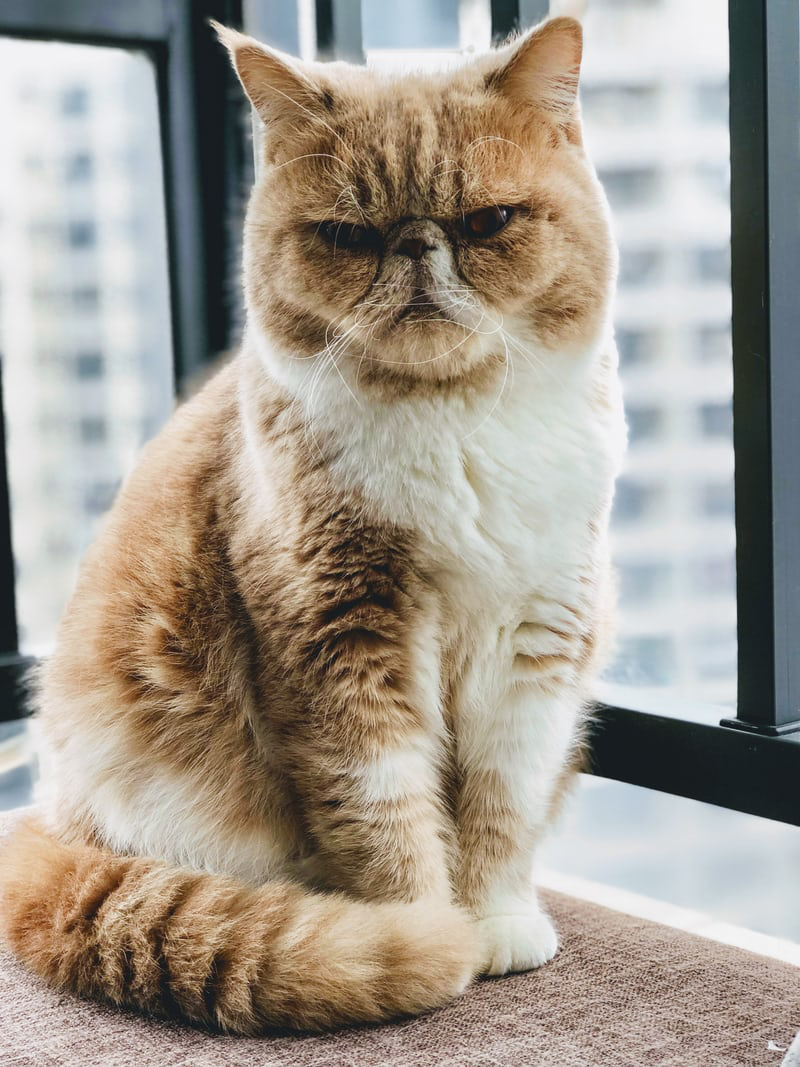

In [ ]:
input_image

In [ ]:
device = "cuda"
model = models.vgg16_bn(pretrained=True)

In [ ]:
model.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
class LayerHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.output = output


def plot_layer_output(layer_data, name, step=None):
    """
    Log visualization of
    """

    b, d, w, h = layer_data.size()
    nrow = int(min(d, 64) ** 0.5)

    outputs = list(map(lambda x: x.unsqueeze(0), layer_data[0]))
    grid = utils.make_grid(outputs[: min(d, 64)], nrow=nrow, normalize=True)

    fig = plt.figure(figsize=(nrow, nrow))
    plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))

    experiment.log_figure(figure=fig, figure_name=name, step=step)


def plot_filter_response(layer_data, name, c="blue", step=None):
    b, d, w, h = layer_data.size()

    outputs = list(map(lambda x: x.cpu().detach().numpy().mean(), layer_data[0]))
    fig = plt.figure(figsize=(10, 8))
    plt.bar(x=[i for i in range(len(outputs))], height=outputs, color=c)
    plt.ylabel("Mean Activation")
    plt.xlabel("Filters")

    max_act = sorted(range(len(outputs)), key=lambda sub: outputs[sub])[-3:]
    plt.title(f"Max Mean Activation Index {max_act}")

    experiment.log_figure(figure=fig, figure_name=name, step=step)


def plot_filters(tensor, name, ch=0, step=None):
    n, c, w, h = tensor.size()

    nrow = int(min(n, 64) ** 0.5)

    if c != 3:
        tensor = tensor[: min(n, 64), ch, :, :].unsqueeze(1)

    grid = utils.make_grid(tensor, nrow=nrow, normalize=True)
    fig = plt.figure(figsize=(nrow, nrow))
    plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

    experiment.log_figure(figure=fig, figure_name=name, step=step)


def restore_image(img_tensor):
    img_tensor = invert_normalize(img_tensor)
    img = torch.clamp(img_tensor, 0, 1)
    img = copy.copy(img_tensor.cpu().data.numpy()[0])
    img = np.round(img * 255)

    img = np.uint8(img).transpose(1, 2, 0)
    img = transforms.ToPILImage()(img)

    return img


def create_optimized_features(model, size, layer, filter_idx, steps):
    img = np.uint8(np.random.uniform(150, 180, (size, size, 3))) // 255
    img = transforms.ToPILImage()(img)

    layer_hook = LayerHook(layer)

    for i in range(8):
        img_tensor = preprocess(img)
        img_tensor = img_tensor.to(device)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor.requires_grad = True

        optimizer = torch.optim.Adam([img_tensor], lr=0.1, weight_decay=1e-6)

        for n in range(steps):
            optimizer.zero_grad()
            model(img_tensor)

            loss = -layer_hook.output[0, filter_idx].mean()
            loss.backward()

            optimizer.step()

        img = restore_image(img_tensor)
        size = int(1.25 * size)
        blur = 2 - (i / 5)

        img = img.resize((size, size), resample=Image.BICUBIC).filter(
            ImageFilter.BoxBlur(blur)
        )

    return img, img_tensor


def create_class_specific_features(model, size, class_idx, steps):
    img = np.uint8(np.random.uniform(150, 180, (size, size, 3))) // 255
    img = transforms.ToPILImage()(img)

    for i in range(8):
        img_tensor = preprocess(img)
        img_tensor = img_tensor.to(device)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor.requires_grad = True

        optimizer = torch.optim.Adam([img_tensor], lr=0.1, weight_decay=1e-6)

        for n in range(steps):
            optimizer.zero_grad()
            out = model(img_tensor)

            loss = -out[0, class_idx].mean()
            loss.backward()

            optimizer.step()

        img = restore_image(img_tensor)
        size = int(1.25 * size)
        blur = 2 - (i / 5)

        img = img.resize((size, size), resample=Image.BICUBIC).filter(
            ImageFilter.BoxBlur(blur)
        )

    return img, img_tensor

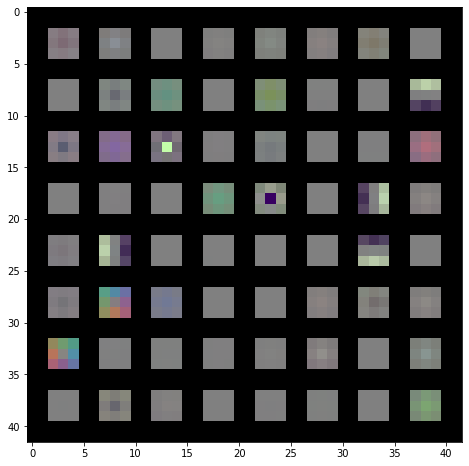

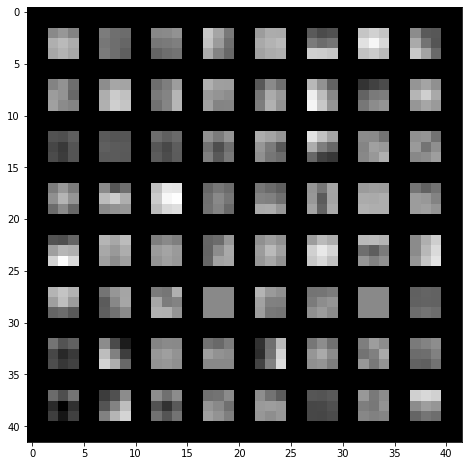

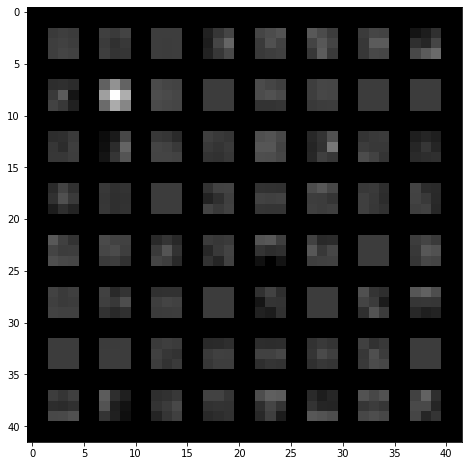

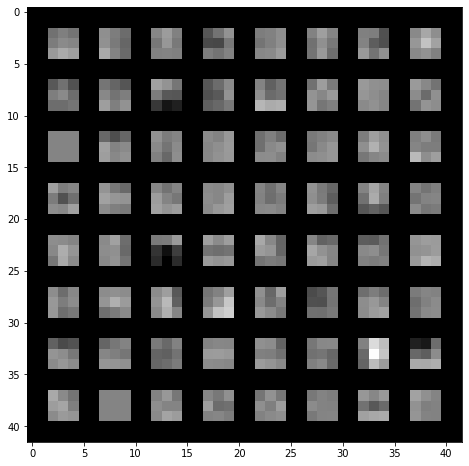

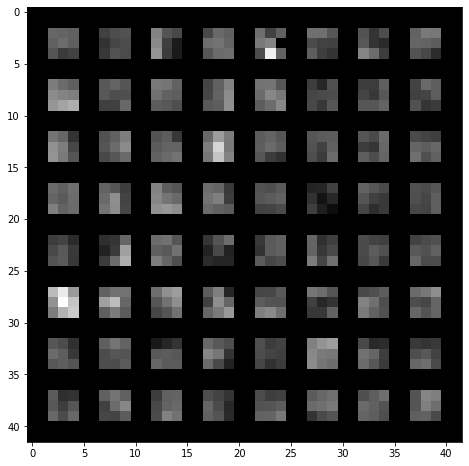

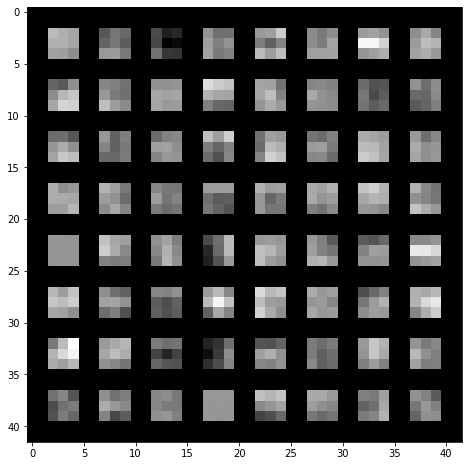

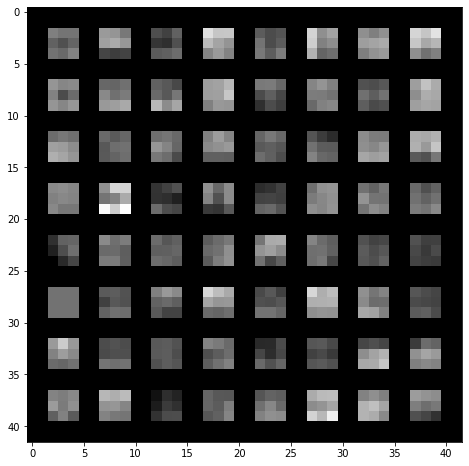

In [ ]:
# Plot the weights for the first 5 convolution layers
layer_ids = [0, 3, 7, 10, 20, 30, 40]

for layer_id in layer_ids:
    layer = model.features[layer_id]
    plot_filters(layer.weight, f"vgg16/layer-{layer_id}/filters", step=layer_id)

In [ ]:
layer_hooks = []
for layer_id in layer_ids:
    layer = model.features[layer_id]
    layer_hook = LayerHook(layer)
    layer_hooks.append(layer_hook)

In [ ]:
relu_hooks = []
for layer_id in layer_ids:
    relu = model.features[layer_id + 1]
    relu_hook = LayerHook(relu)
    relu_hooks.append(relu_hook)

In [ ]:
out = model(input_batch.to(device))

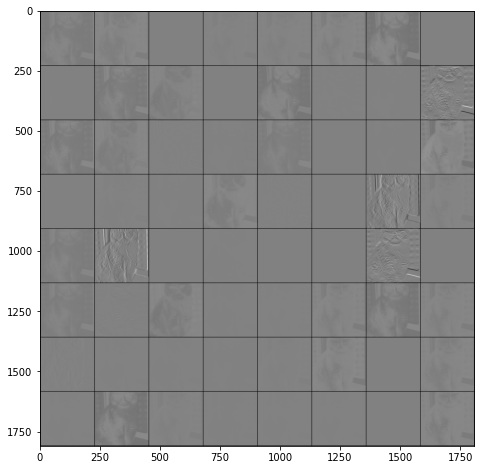

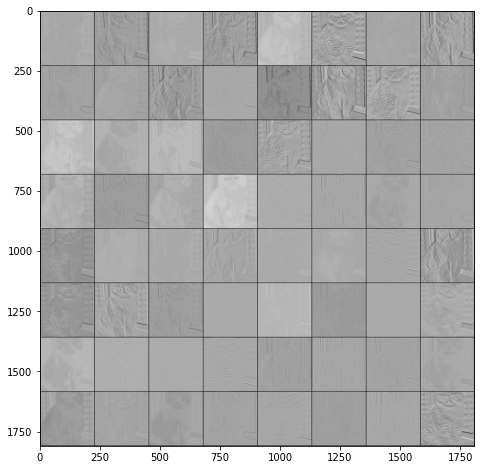

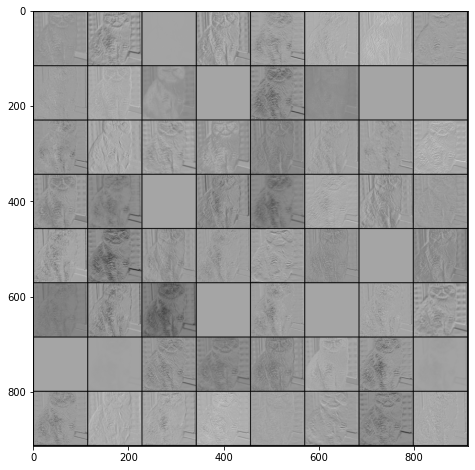

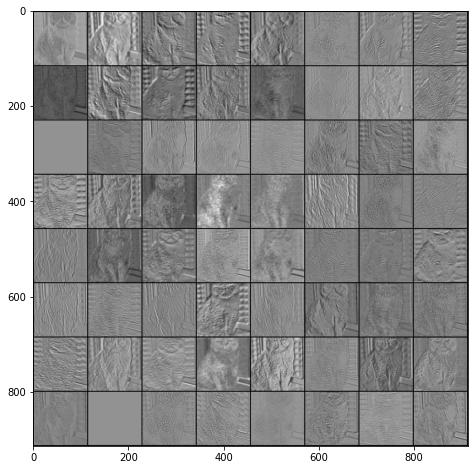

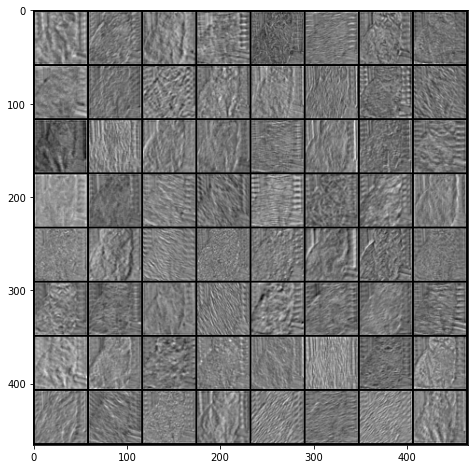

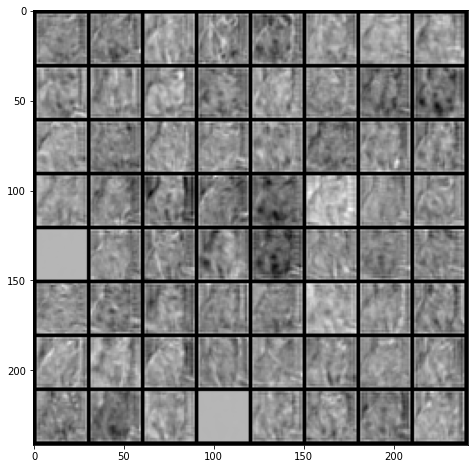

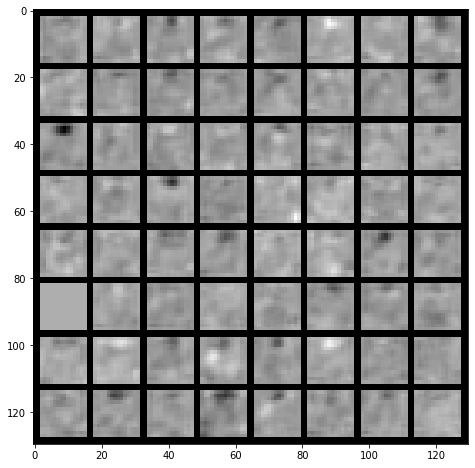

In [ ]:
for layer_id, layer_hook in zip(layer_ids, layer_hooks):
    output_data = layer_hook.output.data
    plot_layer_output(
        output_data, f"vgg16bn/layer-{layer_id}/featuremap/{img_id}", step=layer_id
    )

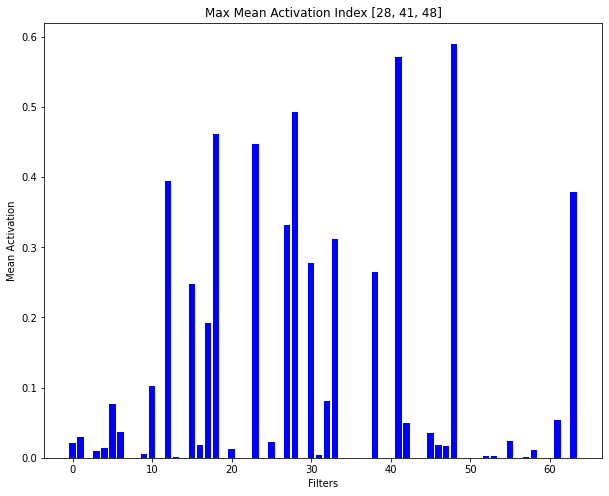

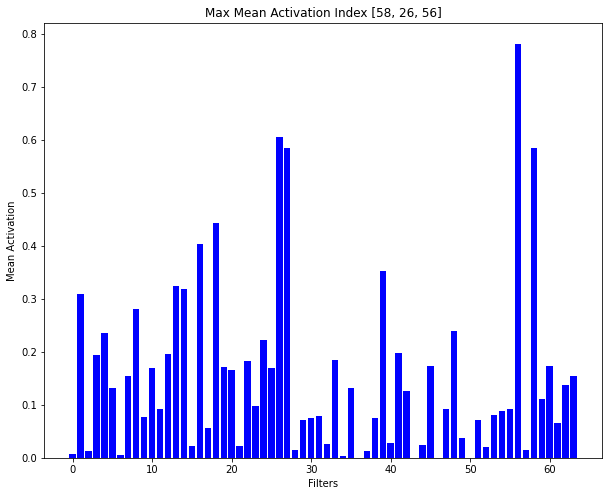

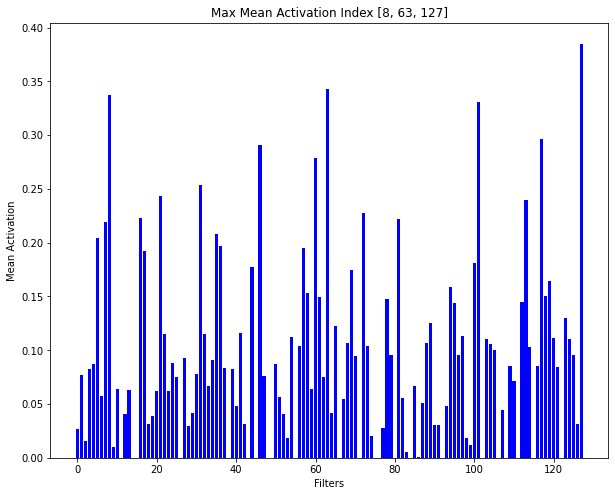

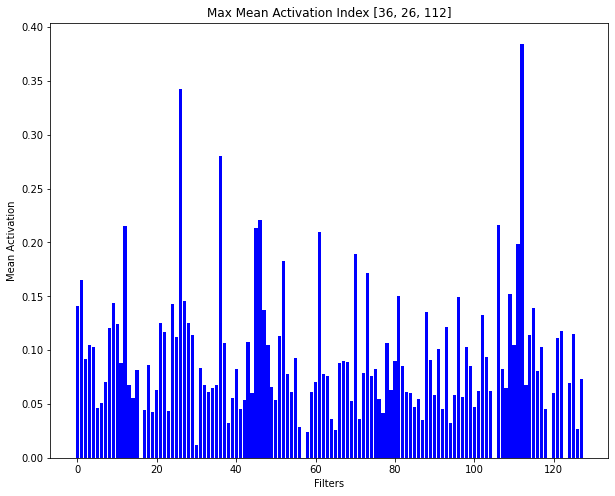

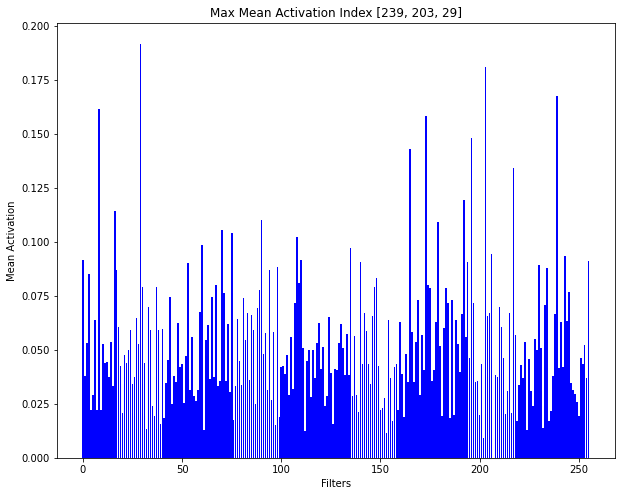

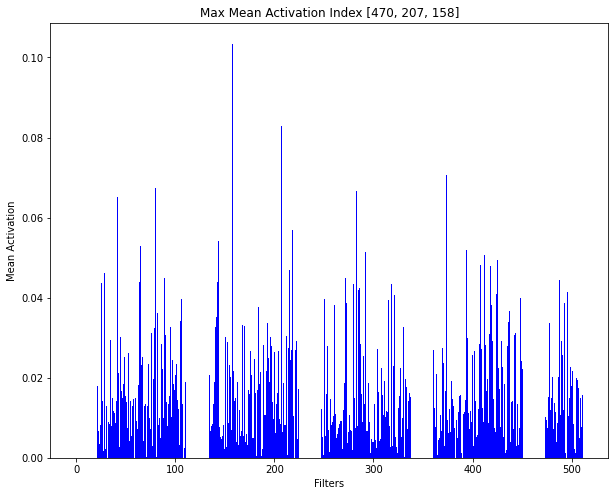

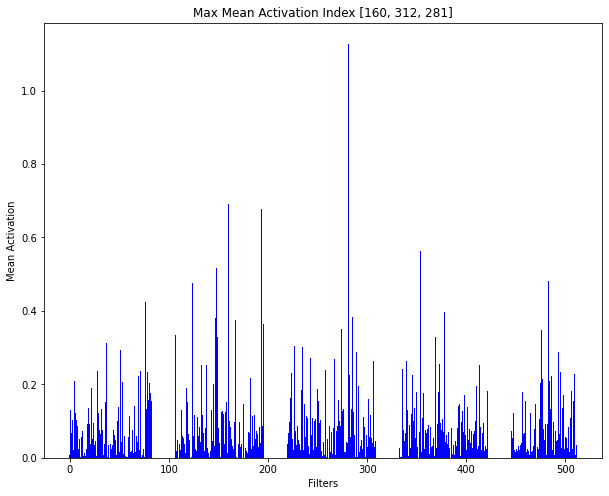

In [ ]:
for layer_id, relu_hook in zip(layer_ids, relu_hooks):
    output_data = relu_hook.output.data
    plot_filter_response(
        output_data, f"vgg16bn/layer-{layer_id}/response/{img_id}", step=layer_id
    )

In [ ]:
filter_id_map = {
    0: [28, 41, 48],
    3: [56, 58],
    7: [127],
    10: [112],
    20: [29],
    30: [158],
    40: [281],
}

In [ ]:
opt_images = []

for layer_id in layer_ids:
    layer = model.features[layer_id]
    filter_ids = filter_id_map[layer_id]

    for filter_id in filter_ids:
        opt_image, img_tensor = create_optimized_features(
            model, 56, layer, filter_id, 25
        )
        opt_images.append(
            {
                "image_name": f"vgg16bn/layer-{layer_id}/filter-{filter_id}/optimized_image",
                "image": opt_image,
            }
        )

In [ ]:
for opt_image in opt_images:
    image_name, image = opt_image["image_name"], opt_image["image"]
    layer_id = int(image_name.split("/")[1].split("-")[-1])

    experiment.log_image(image_data=image, name=image_name, step=layer_id)

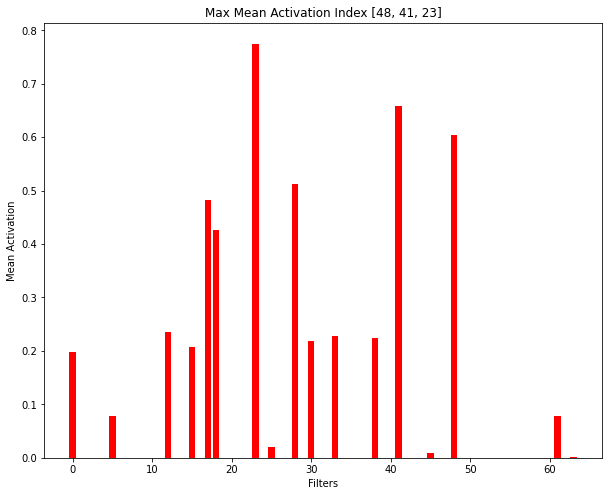

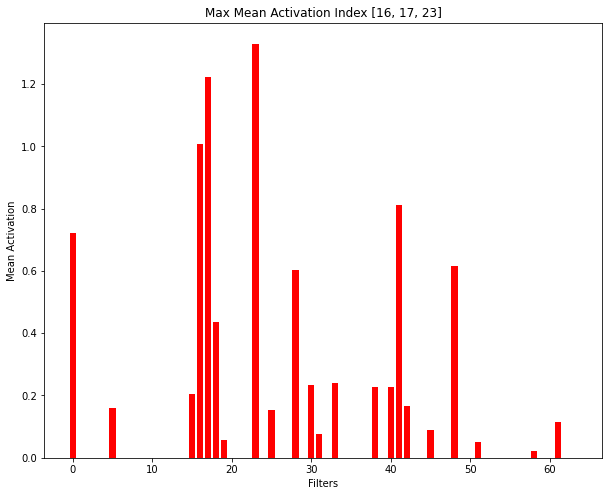

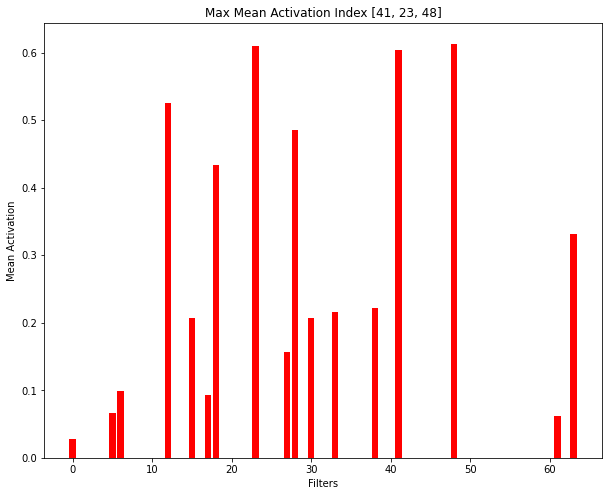

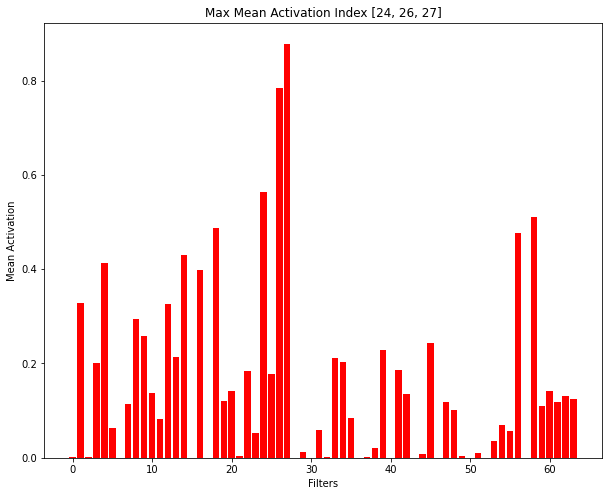

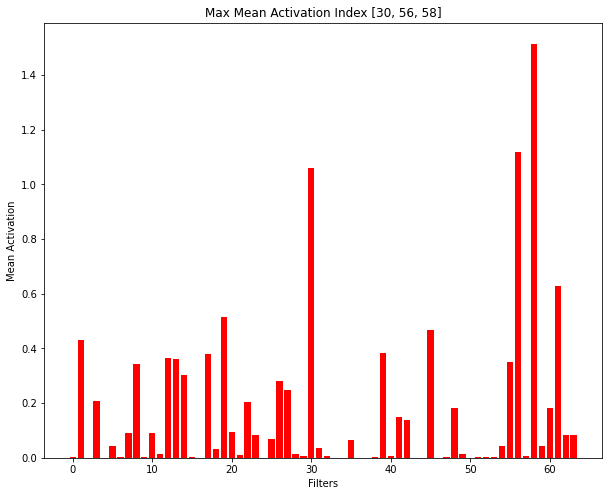

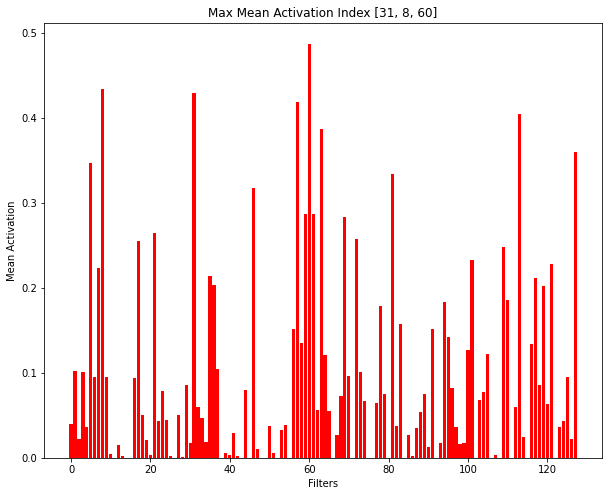

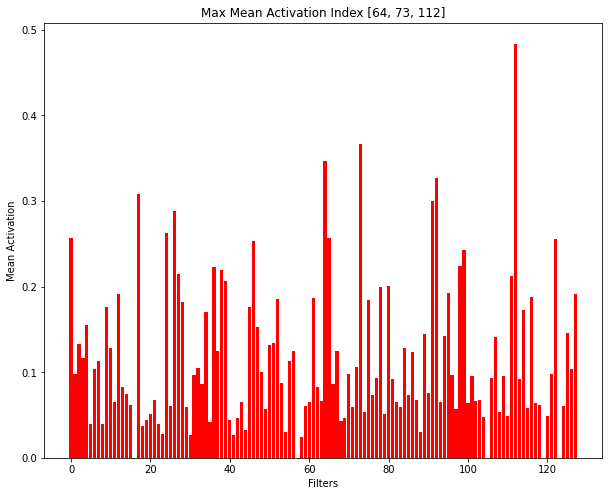

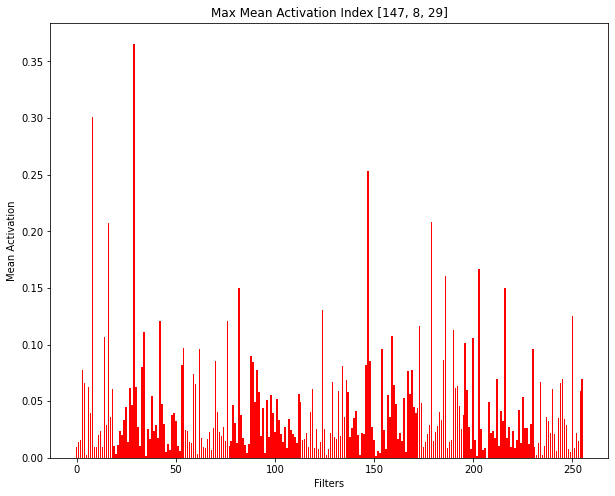

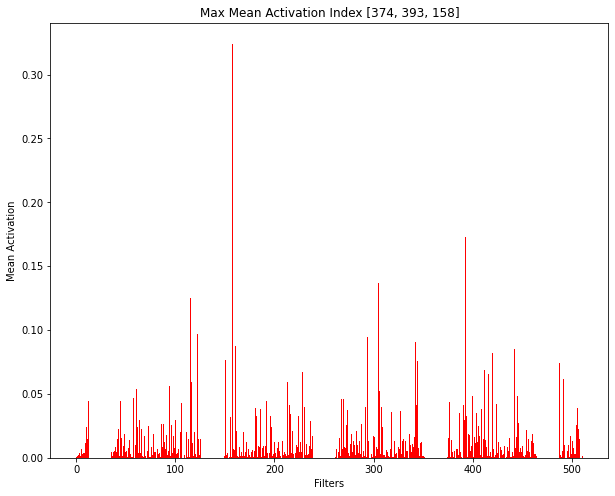

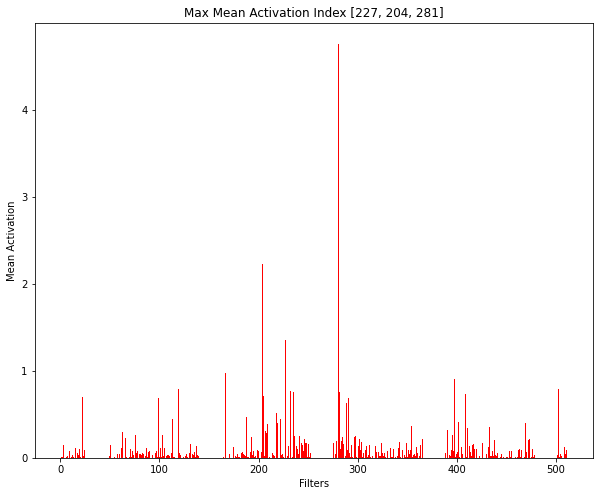

In [ ]:
for img in opt_images:
    image_name = img["image_name"]

    layer_id = int(image_name.split("/")[1].split("-")[-1])
    filter_id = int(image_name.split("/")[2].split("-")[-1])

    relu = model.features[layer_id + 1]
    relu_hook = LayerHook(relu)

    model(preprocess(img["image"]).unsqueeze(0).to(device))

    output_data = relu_hook.output.data
    plot_filter_response(
        output_data,
        f"vgg16bn/layer-{layer_id}/filter-{filter_id}/response/optimized_image",
        step=layer_id,
        c="red",
    )

In [ ]:
class_label_map = {}
for cid, label in enumerate(idx2label):
    class_label_map[label] = cid

In [ ]:
class_labels = ["table_lamp", "volcano", "stopwatch", "parachute", "traffic_light"]
class_opt_images = []

for label in class_labels:
    class_id = class_label_map[label]
    class_opt_image, img_tensor = create_class_specific_features(
        model, 56, class_id, 30
    )
    class_opt_images.append(
        {
            "image_name": f"vgg16bn/class-{class_id}/class_optimized_image",
            "image": class_opt_image,
        }
    )

In [ ]:
for img in class_opt_images:
    experiment.log_image(img["image"], img["image_name"])

In [ ]:
selected_class_idx = [class_label_map[i] for i in class_labels]

In [ ]:
predictions = []
pred_labels = []

for img in class_opt_images:
    img_tensor = preprocess(img["image"])
    out = model(img_tensor.unsqueeze(0).to(device))

    prediction = torch.argmax(out[0]).detach().cpu().numpy().tolist()
    predictions.append(prediction)
    pred_labels.append(idx2label[prediction])

In [ ]:
pred_labels

['table_lamp', 'volcano', 'stopwatch', 'parachute', 'traffic_light']

In [ ]:
class_labels

['table_lamp', 'volcano', 'stopwatch', 'parachute', 'traffic_light']